## Plot of professions onto a gender direction

In [135]:
import sys
sys.path.append("..")
sys.path.append("../data")
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/sets_palabras")

import tests
import directions

import json
import gensim
import re
import random
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import cross_val_score, cross_validate
import datetime

In [2]:
# Biased
biased_model = KeyedVectors.load('../data/embeddings/keyedvectors/model_esp.kv', mmap='r')

In [3]:
# Debiased with INLP
inlp_debiased_model = KeyedVectors.load('../data/embeddings/keyedvectors/ES_inlp_debiased_model.kv', mmap='r')

In [4]:
# Debiased with INLP-ES
inlpES_debiased_model = KeyedVectors.load('../data/embeddings/keyedvectors/inlpES_debiased_model.kv', mmap='r')

In [6]:
with open('../data/sets_palabras/ES/ES_definitional_pairs.json', "r", encoding='utf-8') as f:
    ES_defs = json.load(f)

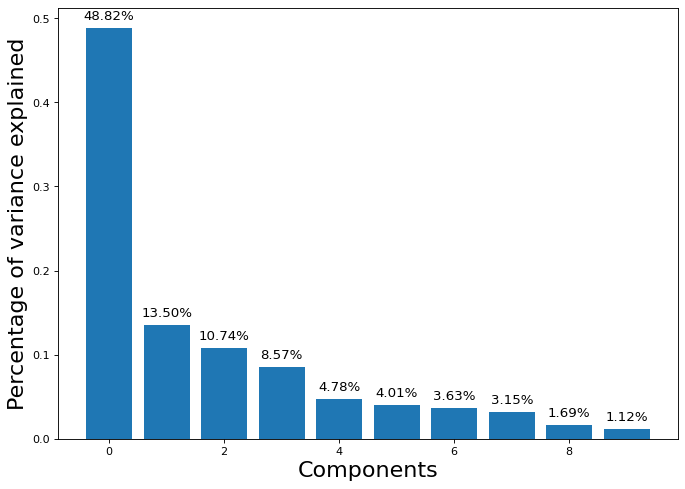

(20, 300)
(300,)
(20, 10)
(20,)


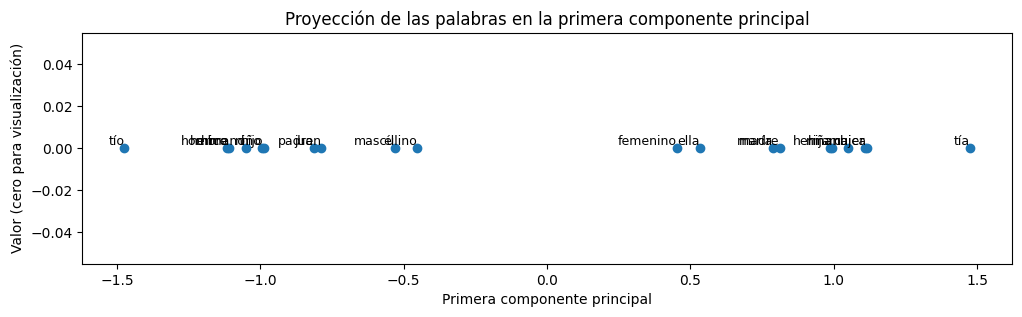

In [7]:
import sys
sys.path.append("../src")
import directions

dPCA = directions.get_gender_direction_PCA(ES_defs, biased_model)

In [8]:
dPCA = - dPCA

In [18]:
def get_top_10_biased(professions, model, gender_direction):
    
    top_10_most_biased = []
    professions_dict = {}
    
    for profession in professions:

        if profession[0] not in model or profession[1] not in model or profession[2] not in model or profession[3] not in model:
            continue # ignore the pair

        # Projections
        proy_sg_f = model[profession[0]].dot(gender_direction)
        proy_sg_m = model[profession[1]].dot(gender_direction)
        proy_pl_m = model[profession[2]].dot(gender_direction)
        proy_pl_f = model[profession[3]].dot(gender_direction)

        gender_diference = abs(proy_sg_f + proy_pl_f) - abs(proy_sg_m + proy_pl_m)
        
        if len(top_10_most_biased) < 10: # add to array with top 10 biased for plotting
            top_10_most_biased.append(gender_diference)
            professions_dict[gender_diference] = profession
            top_10_most_biased.sort()
            
        elif gender_diference > top_10_most_biased[0]: # substitute the first profession
            professions_dict.pop(top_10_most_biased[0]) 
            top_10_most_biased[0] = gender_diference
            professions_dict[gender_diference] = profession

    return professions_dict

In [19]:
get_top_10_biased(professions_clean, biased_model, dPCA)

{2.5952773: ['bailarina', 'bailarín', 'bailarines', 'bailarinas'],
 1.8176681: ['coordinadora', 'coordinador', 'coordinadores', 'coordinadoras'],
 1.8249717: ['educadora', 'educador', 'educadores', 'educadoras'],
 -0.1002765: ['farmacéutica',
  'farmacéutico',
  'farmacéuticos',
  'farmacéuticas'],
 2.2446766: ['cocinera', 'cocinero', 'cocineros', 'cocineras'],
 0.77277553: ['directiva', 'directivo', 'directivos', 'directivas'],
 0.054276884: ['crítica', 'crítico', 'críticos', 'críticas'],
 1.3973567: ['consultora', 'consultor', 'consultores', 'consultoras'],
 3.3728974: ['actriz', 'actor', 'actores', 'actrices'],
 3.2310512: ['embajadora', 'embajador', 'embajadores', 'embajadoras']}

In [20]:
get_top_10_biased(professions_clean, inlp_debiased_model, dPCA_INLP)

{-0.12396228: ['bailarina', 'bailarín', 'bailarines', 'bailarinas'],
 -0.101812266: ['coordinadora',
  'coordinador',
  'coordinadores',
  'coordinadoras'],
 -0.4243822: ['educadora', 'educador', 'educadores', 'educadoras'],
 -0.17864572: ['farmacéutica',
  'farmacéutico',
  'farmacéuticos',
  'farmacéuticas'],
 0.6216403: ['cocinera', 'cocinero', 'cocineros', 'cocineras'],
 0.4682852: ['científica', 'científico', 'científicos', 'científicas'],
 -0.12010522: ['directiva', 'directivo', 'directivos', 'directivas'],
 -0.048179865: ['crítica', 'crítico', 'críticos', 'críticas'],
 -0.04938637: ['consultora', 'consultor', 'consultores', 'consultoras'],
 0.7316669: ['criada', 'criado', 'criados', 'criadas']}

In [140]:
def plot_on_gender_direction(professions, model, gender_direction):
    """
    Given a list of professions of the form [[singular F, singular M, plural M, plural F],[],...],ç
    generate a plot of projections onto the gender direction
    :param professions: 
    :param model: 
    :param gender_direction: 
    """

    # 1. Compute average gender difference 

    n = 0
    
    avg_sg_m = 0 # Media de singulares m 
    avg_sg_f = 0 # Media de singulares f
    avg_pl_m = 0 # Media de plurales m
    avg_pl_f = 0 # Media de plurales m

    for profession in professions:

        if profession[0] not in model or profession[1] not in model or profession[2] not in model or profession[3] not in model:
            continue # ignore the pair 

        n = n + 1
        
        # Projections
        proy_sg_f = model[profession[0]].dot(gender_direction)
        proy_sg_m = model[profession[1]].dot(gender_direction)
        proy_pl_m = model[profession[2]].dot(gender_direction)
        proy_pl_f = model[profession[3]].dot(gender_direction)

        avg_sg_m = avg_sg_m + proy_sg_m
        avg_sg_f = avg_sg_f + proy_sg_f
        avg_pl_m = avg_pl_m + proy_pl_m
        avg_pl_f = avg_pl_f + proy_pl_f

    avg_sg_m = avg_sg_m/n
    avg_sg_f = avg_sg_f/n
    avg_pl_m = avg_pl_m/n
    avg_pl_f = avg_pl_f/n

    avg_gender_diference = abs(avg_sg_f + avg_pl_f) - abs(avg_sg_m + avg_pl_m)

    # 2. Plot 10 most biased professions

    professions_top_10_biased = get_top_10_biased(professions, model, gender_direction).values()
    i = 0
    x_coords = []
    y_coords = []
    word_labels = []

    for profession in professions_top_10_biased:

        i = i+1

        y_coords.append(i)
        y_coords.append(i)
        y_coords.append(i)
        y_coords.append(i)    

        # Projections
        proy_sg_f = model[profession[0]].dot(gender_direction)
        proy_sg_m = model[profession[1]].dot(gender_direction)
        proy_pl_m = model[profession[2]].dot(gender_direction)
        proy_pl_f = model[profession[3]].dot(gender_direction)
        
        x_coords.append(proy_sg_f)
        word_labels.append(profession[0])      
        
        x_coords.append(proy_sg_m)
        word_labels.append(profession[1])

        x_coords.append(proy_pl_m)
        word_labels.append(profession[2])

        x_coords.append(proy_pl_f)
        word_labels.append(profession[3])

    fig=plt.figure(figsize=(10.2, 8), dpi=80)
    
    # Scatter points
    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):

        if (k+1)%4==0: 
            color = '#c3ebce' # plural femenine
            
        elif (k+2)%4==0:
            color = '#e2d1ed' # plural masculine
            
        elif (k+3)%4==0:
            color = '#d7b7ed' # singular masculine
            
        else: 
            color ='#8deba7' # singular femenine
            
        plt.scatter(x, y, color=color)

    # Labels
    k = 0
    for (label1, x1, y1), (label2, x2, y2) in zip(*[iter(zip(word_labels, x_coords, y_coords))]*2):
    #print(label1, x1, y1, " / ", label2, x2, y2)
        
        if(k == 1):
            k = 0
            continue  # we are iterating over plurals
        else:
            k = 1

        plt.annotate(f'{label1} / {label2}', 
                     xy=(1, y1), xytext=(0, 0), textcoords='offset points', fontsize=12,
                     color="black")  # Default text color is black

        # Add different colors for feminine, "/", and masculine
        #plt.text(0, y1, label1, fontsize=12, color="#4c0185", ha='right')
        #plt.text(0, y1, " / ", fontsize=12, color="black", ha='center')
        #plt.text(0, y1, label2, fontsize=12, color="#d7b7ed", ha='left')

    plt.xlim(-2.5, 2.5)
    plt.ylim(0, max(y_coords) + 3.5)

    plt.axvline(x=0, color='#f1f739', label='Projection = 0')    
    plt.axvline(x=avg_sg_m, color='#d7b7ed', label=f'Mean singular masc. projection')
    plt.axvline(x=avg_pl_m, color='#e2d1ed', label=f'Mean plural masc. projection')
    plt.axvline(x=avg_sg_f, color='#8deba7', label=f'Mean singular fem. projection')
    plt.axvline(x=avg_pl_f, color='#c3ebce', label=f'Mean plural fem. projection')

    plt.legend(loc='upper right')
    plt.suptitle(f"Mean gender difference: {avg_gender_diference}", y=0.93)
    
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    plt.savefig(f"plot_{timestamp}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

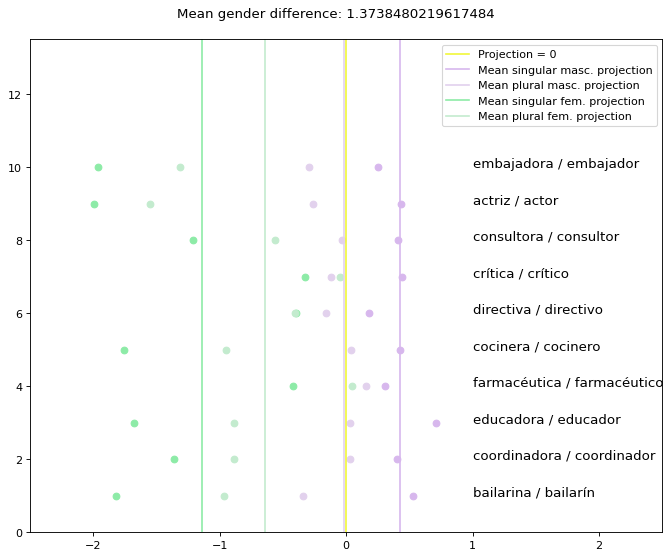

In [141]:
plot_on_gender_direction(professions_clean, biased_model, dPCA)

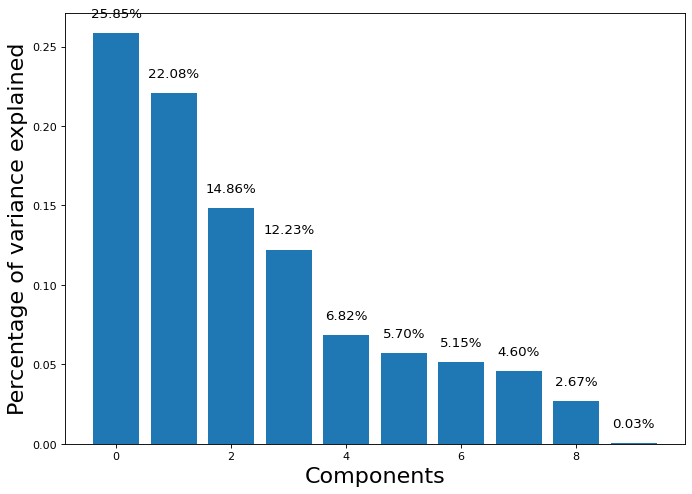

(20, 300)
(300,)
(20, 10)
(20,)


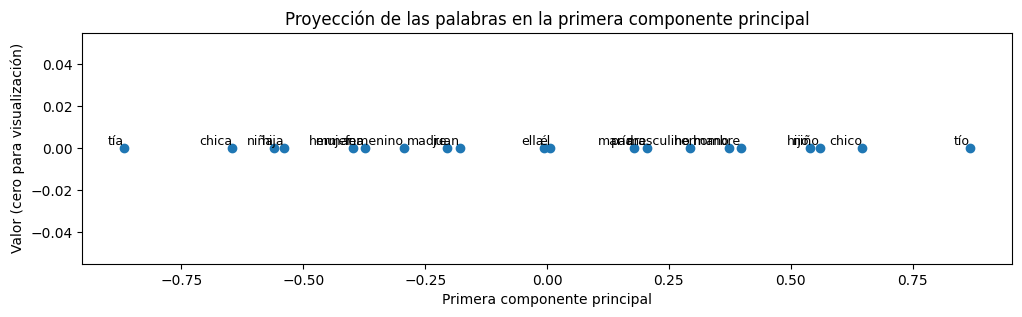

In [12]:
dPCA_INLP = directions.get_gender_direction_PCA(ES_defs, inlp_debiased_model)

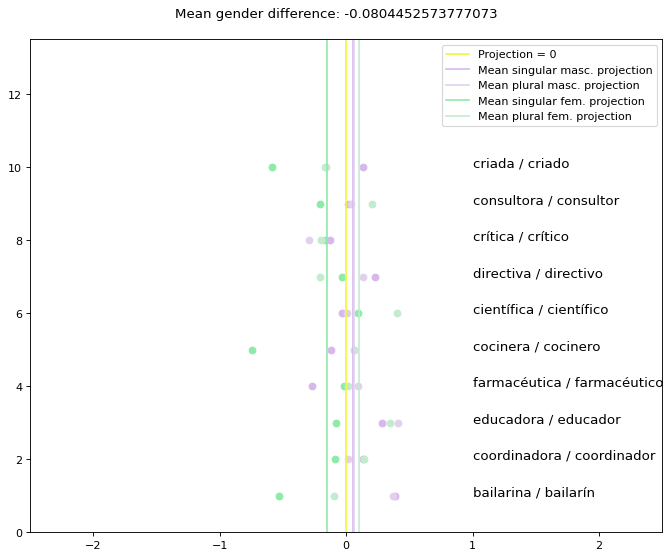

In [142]:
plot_on_gender_direction(professions_clean, inlp_debiased_model, dPCA_INLP)

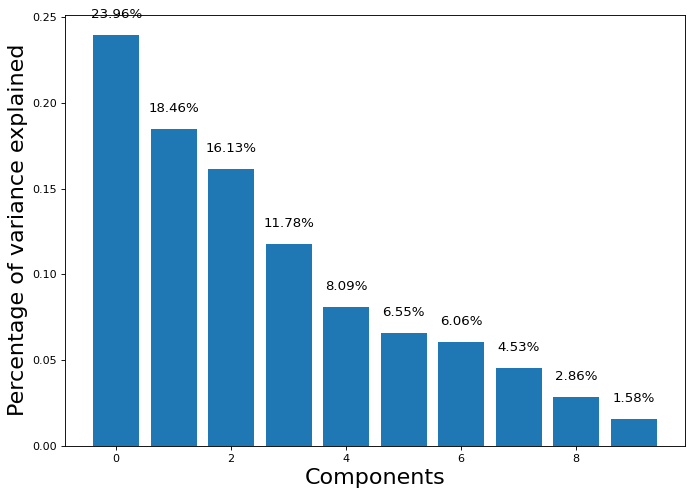

(20, 300)
(300,)
(20, 10)
(20,)


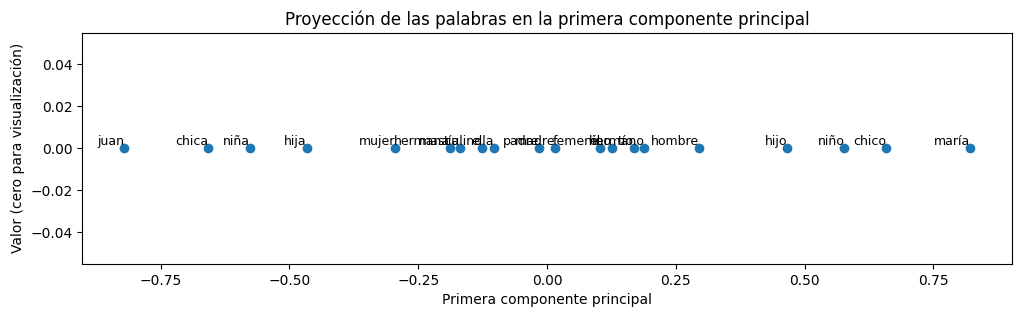

In [14]:
dPCA_INLPGram = directions.get_gender_direction_PCA(ES_defs, inlpES_debiased_model)

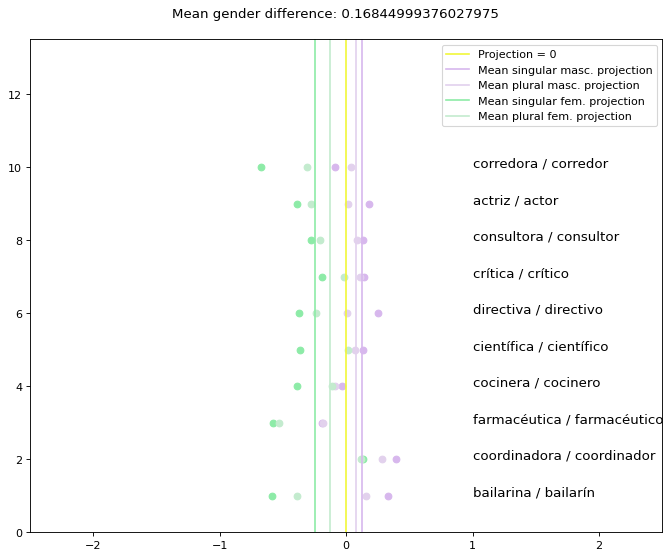

In [143]:
plot_on_gender_direction(professions_clean, inlpES_debiased_model, dPCA_INLPGram)

# -------------------------------------------------------------------------------

In [ ]:
def plot_on_gender_direction_old(professions, model, gender_direction):
    """
    Given a list of professions of the form [[singular F, singular M, plural M, plural F],[],...],ç
    generate a plot of projections onto the gender direction
    :param professions: 
    :param model: 
    :param gender_direction: 
    """
    x_coords = []
    y_coords = []
    i = 0
    top = 10
        
    word_labels = []
    
    avg_sg_m = 0 # Media de singulares m 
    avg_sg_f = 0 # Media de singulares f
    avg_pl_m = 0 # Media de plurales m
    avg_pl_f = 0 # Media de plurales m

    random.shuffle(professions)
    
    for profession in professions:

        i = i+1
        #if i == top: break
            
        if profession[0] not in model or profession[1] not in model or profession[2] not in model or profession[3] not in model:
            continue # ignore the pair

        y_coords.append(i)
        y_coords.append(i)
        y_coords.append(i)
        y_coords.append(i)
        

        # Projections
        proy_sg_f = model[profession[0]].dot(gender_direction)
        proy_sg_m = model[profession[1]].dot(gender_direction)
        proy_pl_m = model[profession[2]].dot(gender_direction)
        proy_pl_f = model[profession[3]].dot(gender_direction)
        
        x_coords.append(proy_sg_f)
        word_labels.append(profession[0])      
        
        x_coords.append(proy_sg_m)
        word_labels.append(profession[1])

        x_coords.append(proy_pl_m)
        word_labels.append(profession[2])

        x_coords.append(proy_pl_f)
        word_labels.append(profession[3])

        avg_sg_m = avg_sg_m + proy_sg_m
        avg_sg_f = avg_sg_f + proy_sg_f
        avg_pl_m = avg_pl_m + proy_pl_m
        avg_pl_f = avg_pl_f + proy_pl_f

    avg_sg_m = avg_sg_m/i
    avg_sg_f = avg_sg_f/i
    avg_pl_m = avg_pl_m/i
    avg_pl_f = avg_pl_f/i
    
    fig=plt.figure(figsize=(10, 7), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):

        if (k+1)%4==0: 
            color = 'purple' # plural femenine
            
        elif (k+2)%4==0:
            color = 'green' # plural masculine
            
        elif (k+3)%4==0:
            color = 'blue' # singular masculine
            
        else: 
            color ='red' # singular femenine

        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=10,
                     color=color)

    plt.xlim(-1, 1)
    plt.ylim(0, 40)

    plt.axvline(x=0, color='k', linestyle='--', label='Neutralidad (proy=0) de género semántico')    
    plt.axvline(x=avg_sg_m, color='blue', linestyle='--', label=f'Average singular masculine: {avg_sg_m}')
    plt.axvline(x=avg_sg_f, color='red', linestyle='--', label=f'Average singular feminine: {avg_sg_f}')
    plt.axvline(x=avg_pl_m, color='green', linestyle='--', label=f'Average plural masculine: {avg_pl_m}')
    plt.axvline(x=avg_pl_f, color='purple', linestyle='--', label=f'Average plural feminine: {avg_pl_f}')

    plt.legend(loc='upper right')
    plt.title('Visualization of occupation words on gender direction')
    plt.show()


In [18]:
# Load the original professions data
with open('../data/sets_palabras/ES/ES_professions.json', "r", encoding='utf-8') as f:
    professions = json.load(f)

print(f"Total professions in original list: {len(professions)}")

# Clean the professions list
professions_clean = []

for profession in professions:
    if profession[0] != profession[1] and profession[0] in biased_model and profession[1] in biased_model:
        professions_clean.append(profession)

print(f"Total professions in cleaned list: {len(professions_clean)}")
print("First 5 cleaned professions:", professions_clean[:5])

# Save the cleaned list to a new file
output_file = '../data/sets_palabras/ES/ES_professions_clean.json'
with open(output_file, "w", encoding='utf-8') as f:
    json.dump(professions_clean, f, ensure_ascii=False, indent=4)

print(f"Cleaned professions list saved to: {output_file}")

Total professions in original list: 1376
Total professions in cleaned list: 151
First 5 cleaned professions: [['abadesa', 'abad', 'abades', 'abadesas'], ['abogada', 'abogado', 'abogados', 'abogadas'], ['académica', 'académico', 'académicos', 'académicas'], ['accionaria', 'accionario', 'accionarios', 'accionarias'], ['acreedora', 'acreedor', 'acreedores', 'acreedoras']]
Cleaned professions list saved to: ../data/sets_palabras/ES/ES_professions_clean.json


In [10]:
with open('../data/sets_palabras/ES/ES_professions_clean.json', "r", encoding='utf-8') as f:
    professions_clean = json.load(f)

print(len(professions_clean))

61


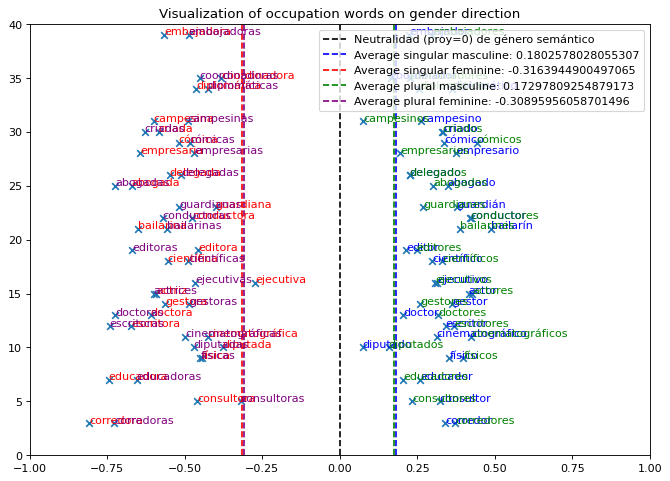

In [23]:
plot_on_gender_direction(professions_clean, biased_model, dGram)

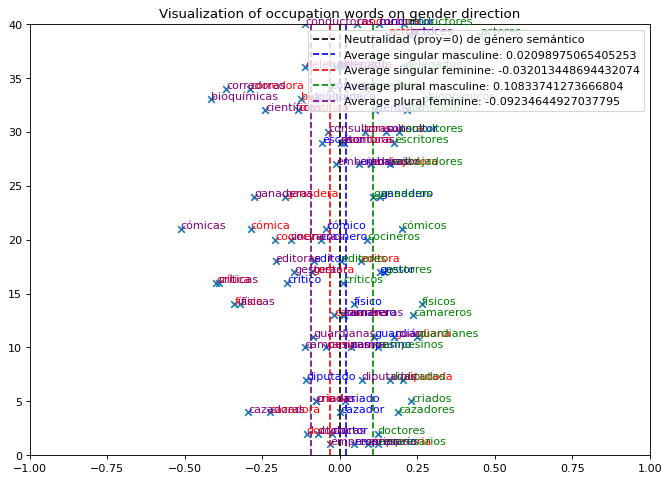

In [24]:
plot_on_gender_direction(professions_clean, inlp_debiased_model, dGram)

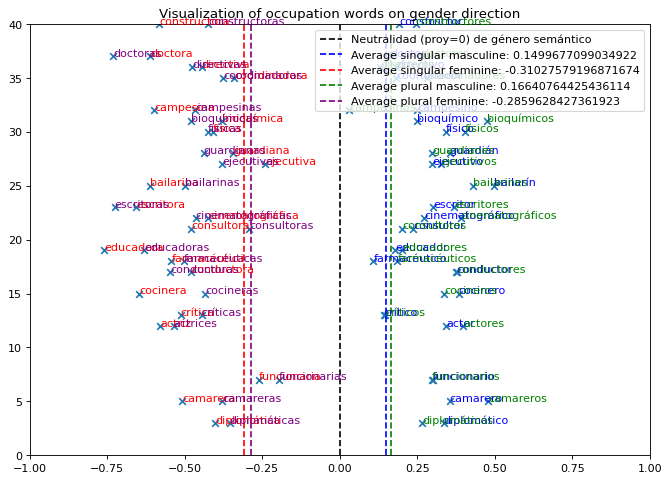

In [25]:
plot_on_gender_direction(professions_clean, inlpES_debiased_model, dGram)

In [33]:
dGram = np.loadtxt("../data/directions/dGram")

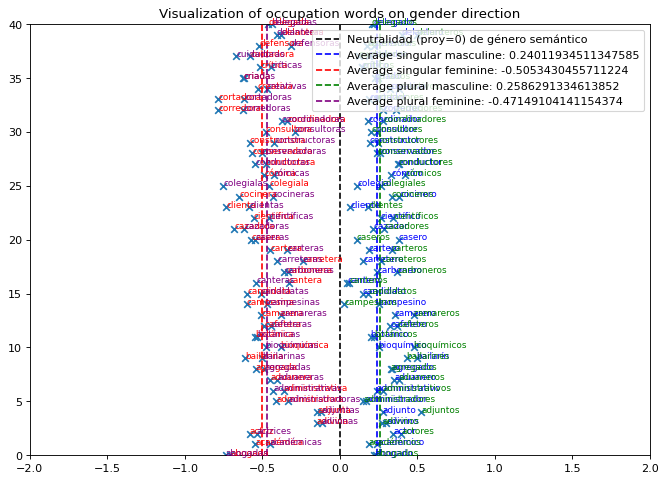

In [36]:
plot_on_gender_direction(professions_clean, inlpES_debiased_model, dGram)